In [1]:
# !pip install timm 

In [2]:
import numpy as np 
import pandas as pd 
import os
import sys
import cv2
from tqdm import tqdm 
import re

import torch
import torchvision 

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# import timm
import matplotlib.pyplot as plt

In [3]:
train_files = pd.read_csv("../input/flir-annotations-csv/filename.csv")
train_annotations = pd.read_csv("../input/flir-annotations-csv/annotations.csv")
train_files= train_files.rename(columns={'id':'image_id'})
train_files = train_files[train_files.columns[3:]]
train = train_annotations.join(train_files, on = 'image_id',how='inner', lsuffix='_left', rsuffix='_right')

In [4]:
train['x'] = -1
train['y'] = -1
train['w'] = -1
train['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x),dtype = np.int32)
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train[['x', 'y', 'w', 'h']] = np.stack(train['bbox'].apply(lambda x: expand_bbox(x)))

In [5]:
images = train["image_id"].unique()
# np.random.shuffle(images)
valid_idx = images[-1772:] # Using a 20% of the data for validation
train_idx = images[:-1772]


In [6]:
valid_df = train[train['image_id'].isin(valid_idx)]
train_df = train[train['image_id'].isin(train_idx)]

In [7]:
train_df.dtypes

image_id           int64
Unnamed: 0         int64
image_id_left      int64
extra_info        object
category_id        int64
iscrowd            int64
id                 int64
segmentation      object
bbox              object
area               int64
image_id_right     int64
width              int64
file_name         object
height             int64
x                  int64
y                  int64
w                  int64
h                  int64
dtype: object

In [8]:
img = cv2.imread("../input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train/thermal_8_bit/FLIR_00001.jpeg")

In [9]:
def get_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
image_dir = "../input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train"
class FlirDataset(Dataset):
    def __init__(self, dataframe, image_dir = image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        file_path = records['file_name'].values[0]
        image = cv2.imread(f'{self.image_dir}/{file_path}', cv2.IMREAD_COLOR)
#         print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
#         target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4 # Car,people,dog and dont remember the last class

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

#Change the last layer of model to support 4 outputs
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = FlirDataset(train_df,image_dir,get_transform())
valid_dataset = FlirDataset(valid_df,image_dir, get_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [16]:
boxes = targets[3]['boxes'].cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()

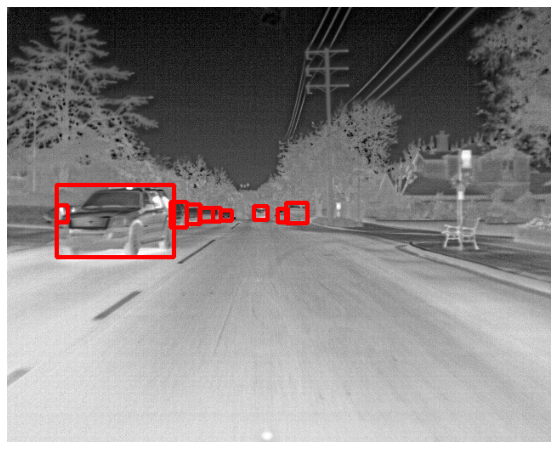

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

In [19]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.2675171494483948
Iteration #100 loss: 0.5529991984367371
Iteration #150 loss: 1.184166431427002
Iteration #200 loss: 0.3570583164691925
Iteration #250 loss: 0.5070450901985168
Iteration #300 loss: 0.46503183245658875
Iteration #350 loss: 0.22762835025787354
Iteration #400 loss: 0.25756457448005676
Iteration #450 loss: 0.6467951536178589
Iteration #500 loss: 0.9771081209182739
Iteration #550 loss: 0.547223687171936


KeyboardInterrupt: 

In [20]:
images, targets, image_ids = next(iter(valid_data_loader))

In [21]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [23]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
# boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
# sample = images[1].permute(1,2,0).cpu().numpy()

In [42]:
box = outputs[0]['boxes'].detach().numpy()
sample = images[0].permute(1,2,0).cpu().numpy()

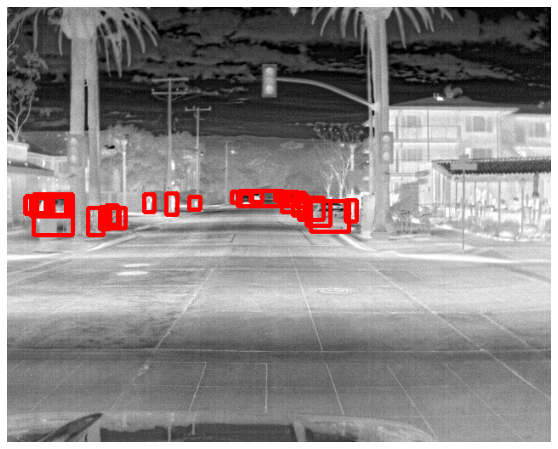

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in box:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [45]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')